In [1]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git

Cloning into 'Facial-Similarity-with-Siamese-Networks-in-Pytorch'...
remote: Enumerating objects: 550, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 550 (delta 6), reused 18 (delta 6), pack-reused 532
Receiving objects: 100% (550/550), 6.32 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
%cd Facial-Similarity-with-Siamese-Networks-in-Pytorch/

/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch


In [3]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0 liblqr-1-0
  libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra libmagickwand-6.q16-6
  libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch inkscape libjxr-tools libwmf0.2-7-gtk
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be

In [4]:
%cd data/faces

/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces


In [5]:
!find -name "*pgm" | xargs -I {} convert {} {}.png

In [6]:
%cd ../../

/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch


In [7]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions

In [8]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## COnfiguration Class

In [9]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class

In [10]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [11]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [14]:
folder_dataset.imgs

[('./data/faces/training/s1/1.pgm', 0),
 ('./data/faces/training/s1/1.pgm.png', 0),
 ('./data/faces/training/s1/10.pgm', 0),
 ('./data/faces/training/s1/10.pgm.png', 0),
 ('./data/faces/training/s1/2.pgm', 0),
 ('./data/faces/training/s1/2.pgm.png', 0),
 ('./data/faces/training/s1/3.pgm', 0),
 ('./data/faces/training/s1/3.pgm.png', 0),
 ('./data/faces/training/s1/4.pgm', 0),
 ('./data/faces/training/s1/4.pgm.png', 0),
 ('./data/faces/training/s1/5.pgm', 0),
 ('./data/faces/training/s1/5.pgm.png', 0),
 ('./data/faces/training/s1/6.pgm', 0),
 ('./data/faces/training/s1/6.pgm.png', 0),
 ('./data/faces/training/s1/7.pgm', 0),
 ('./data/faces/training/s1/7.pgm.png', 0),
 ('./data/faces/training/s1/8.pgm', 0),
 ('./data/faces/training/s1/8.pgm.png', 0),
 ('./data/faces/training/s1/9.pgm', 0),
 ('./data/faces/training/s1/9.pgm.png', 0),
 ('./data/faces/training/s10/1.pgm', 1),
 ('./data/faces/training/s10/1.pgm.png', 1),
 ('./data/faces/training/s10/10.pgm', 1),
 ('./data/faces/training/s10/1

In [12]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


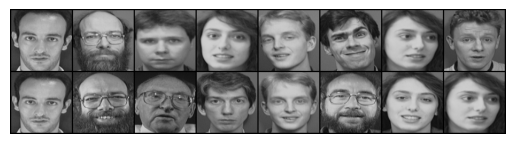

[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [20]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Simple Siamese Network with Neural network

In [22]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [23]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training

In [24]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [26]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.654623031616211

Epoch number 0
 Current loss 1.5357263088226318

Epoch number 1
 Current loss 2.713648796081543

Epoch number 1
 Current loss 1.4266595840454102

Epoch number 2
 Current loss 0.8191081285476685

Epoch number 2
 Current loss 0.7411035299301147

Epoch number 3
 Current loss 3.03747296333313

Epoch number 3
 Current loss 0.38624921441078186

Epoch number 4
 Current loss 0.31999263167381287

Epoch number 4
 Current loss 0.24081262946128845

Epoch number 5
 Current loss 0.1945868730545044

Epoch number 5
 Current loss 0.31764787435531616

Epoch number 6
 Current loss 0.32590317726135254

Epoch number 6
 Current loss 0.2722395658493042

Epoch number 7
 Current loss 0.16321516036987305

Epoch number 7
 Current loss 0.34836044907569885

Epoch number 8
 Current loss 0.16857917606830597

Epoch number 8
 Current loss 0.14348536729812622

Epoch number 9
 Current loss 0.17017129063606262

Epoch number 9
 Current loss 0.08745363354682922

Epoch number 

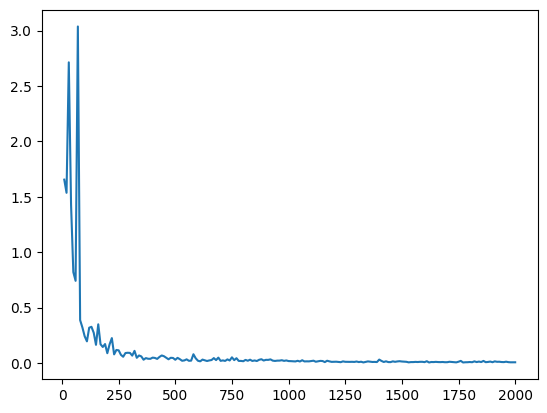

In [27]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Testing

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


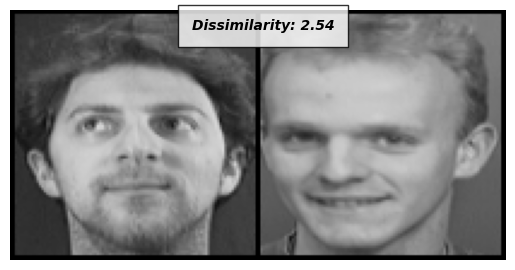

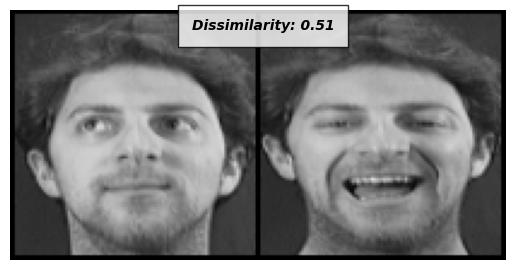

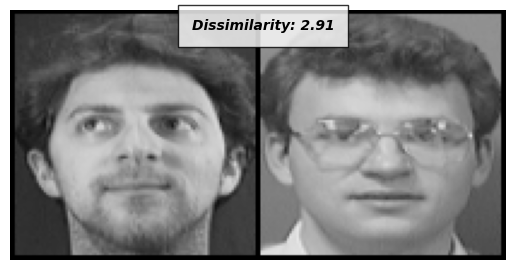

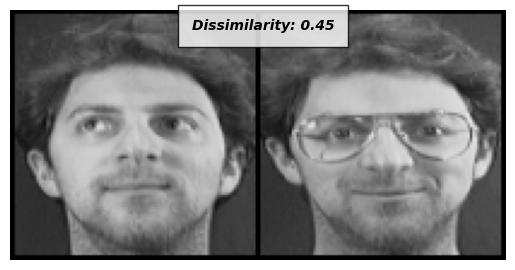

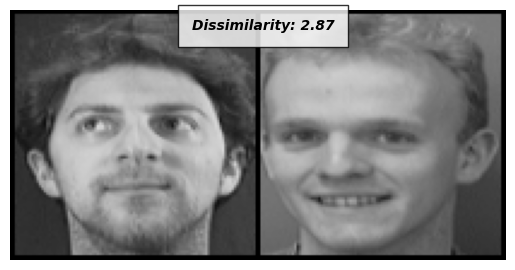

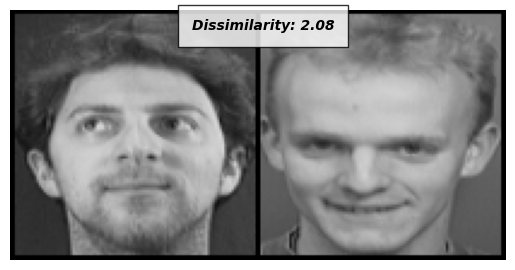

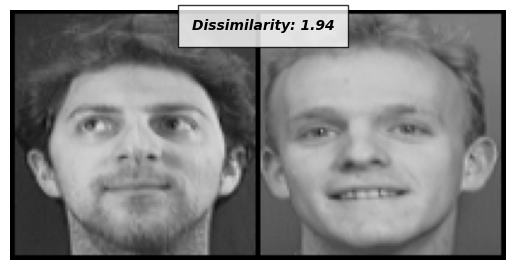

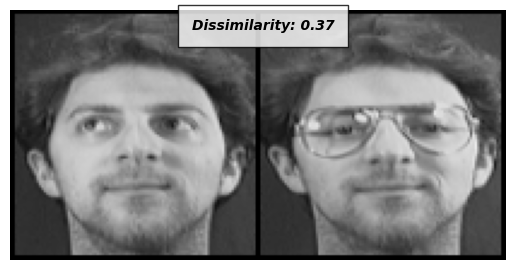

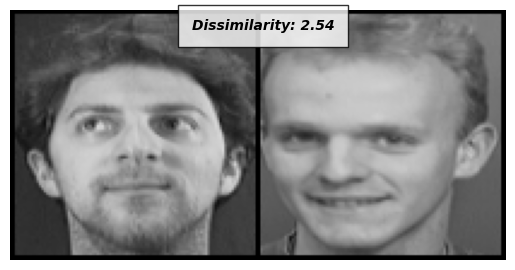

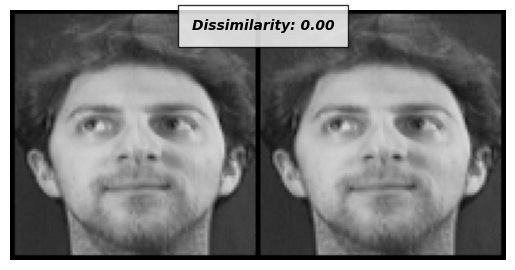

In [28]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))